In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client

In [2]:
%matplotlib inline

In [3]:
%load_ext line_profiler

In [4]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [ ]:
sys.path.append('/home/travis/python_code/satellite_irradiance_optimal_interpolation/satoi/')
import oi as oi

In [5]:
importlib.reload(lf)

<module 'letkf_forecasting' from '/home/travis/python_code/letkf_forecasting/letkf_forecasting.py'>

In [6]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_15.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [7]:
max_lat = sat_15['lat'].max().values + .01
min_lat = sat_15['lat'].min().values - .01
min_long = sat_15['long'].min().values - .01
max_long = sat_15['long'].max().values + .01
print(max_lat)
print(min_lat)
print(min_long)
print(max_long)

33.3037808817
31.1494901105
-111.83381864
-110.008429666


In [8]:
clear_sky_good = xr.DataArray(
    data=(sat_15.GHI.values/sat_14.GHI.values).clip(max=1),
    coords=sat_15.coords)
clear_sky_good = clear_sky_good.rename({'x': 'y_', 'y': 'x_'})
clear_sky_good = clear_sky_good.rename({'y_': 'y', 'x_': 'x'})
sat_15['clear_sky_good'] = clear_sky_good
sat_15 = sat_15.rename({'x': 'west_east', 'y': 'south_north'})

In [8]:
# Need to drop the bad sensors


In [9]:
sensor_CI = sensor_data[['clearsky_index', 'id']]
sensor_CI = sensor_CI.reset_index().pivot(
    index='time', columns='id', values='clearsky_index')
sensor_CI = sensor_CI.resample('5min').mean().dropna() ##Use scipy interpolate instead of this.

In [10]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5
goes15_elevation = 44.1

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([-5781.68704891]), array([-218694.14370625]))

In [11]:
# Better Crop should write as a function into letkf_forecasting
long_min = sensor_loc['lon'].min()
long_max = sensor_loc['lon'].max()
lat_min = sensor_loc['lat'].min()
lat_max = sensor_loc['lat'].max()
long = sat_15.long.values
lat = sat_15.lat.values
min_x = abs(long[0, :] - long_min).argmin()
max_x = abs(long[0, :] - long_max).argmin()
min_y = abs(lat[:, 0] - lat_min).argmin()
max_y = abs(lat[:, 0] - lat_max).argmin()

U_max = wind_15.U.max() # know U is positive
V_max = abs(wind_15.V.min()) # know V is negative

left = int(U_max*60*30/250) + 20
right = 20

up = int(V_max*60*30/250) + 20
down = 20

x_crop = slice(min_x - left, max_x + right)
y_crop = slice(min_y - down, max_y + up)
print('X length: ' + 
      str(max_x + right - (min_x - left)))
print('Y length: ' + 
      str(max_y + up - (min_y - down)))

X length: 469
Y length: 330


In [12]:
U = filters.uniform_filter(wind_15.U, (0, 300, 300), mode='mirror')
V = filters.uniform_filter(wind_15.V, (0, 300, 300), mode='mirror')

In [13]:
wind_15_smooth = wind_15.copy()

In [14]:
wind_15_smooth['U'] = (wind_15.U.dims, U)
wind_15_smooth['V'] = (wind_15.V.dims, V)

In [15]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5
goes15_elevation = 44.1

In [16]:
n_workers = 20
cluster = LocalCluster(n_workers=n_workers, scheduler_port=7001, diagnostics_port=7002)
client = Client(cluster)

In [17]:
wind_ave = wind_15.mean(dim='south_north').mean(dim='west_east').mean(dim='south_north_stag').mean(dim='west_east_stag')

In [18]:
U_ave = wind_ave.U.values
V_ave = wind_ave.V.values

In [19]:
wind_15_ave = wind_15.copy()

In [20]:
U_ave = np.ones_like(wind_15.U.values)*wind_ave.U.values[:, None, None]
V_ave = np.ones_like(wind_15.V.values)*wind_ave.V.values[:, None, None]

In [21]:
wind_15_ave['U'] = (wind_15.U.dims, U_ave)
wind_15_ave['V'] = (wind_15.V.dims, V_ave)

In [56]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 50 #was 5
localization = 30
inflation = 1.1

sat_sig = 0.001 #0.01 #0.05
sensor_sig = 0.1 #0.1 #0.05
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 7303

start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

analysis, analysis_error, background, background_error, advected, time_range = lf.main(
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_ave.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, inflation=inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

time_index: 0
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 1
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 2
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 3
advection_number: 0
advection_number: 1
advection_number: 2


/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


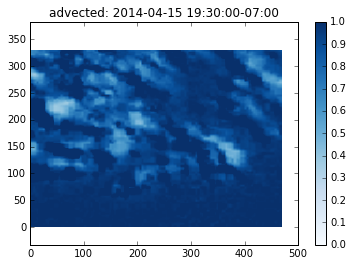

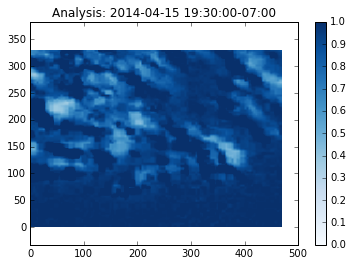

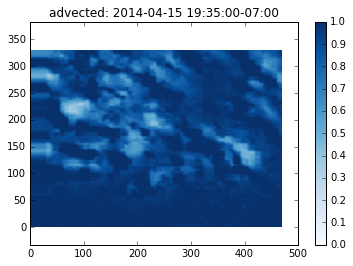

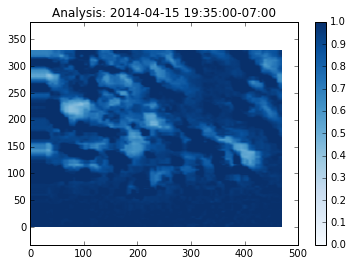

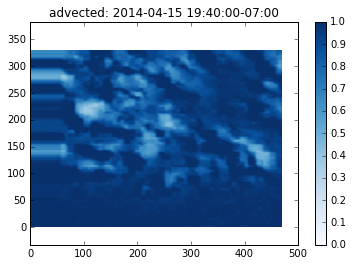

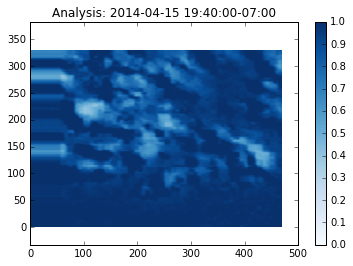

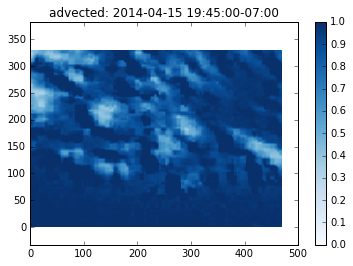

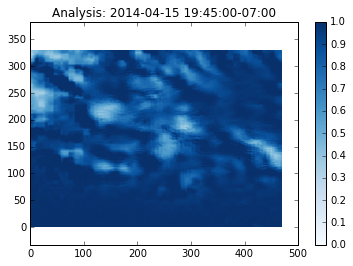

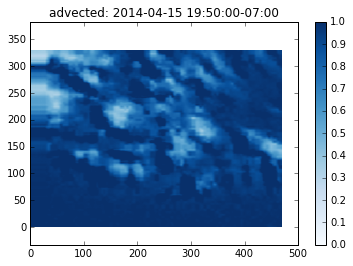

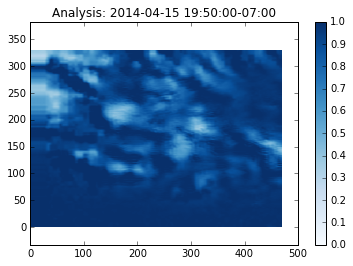

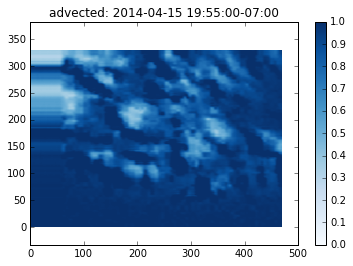

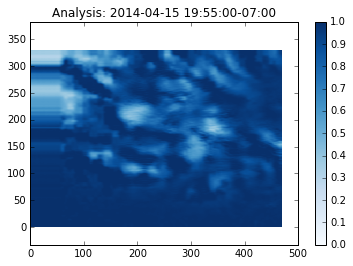

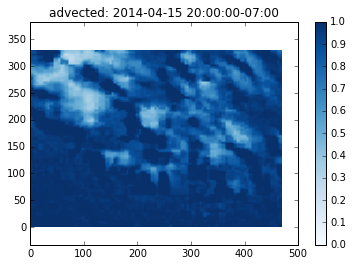

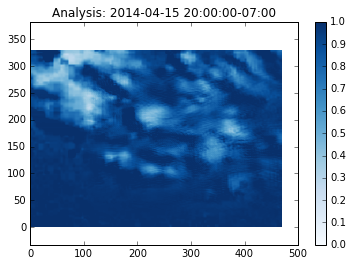

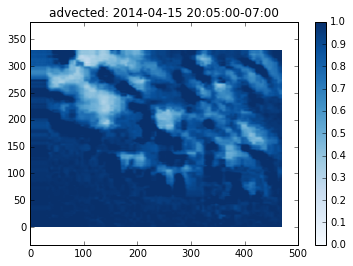

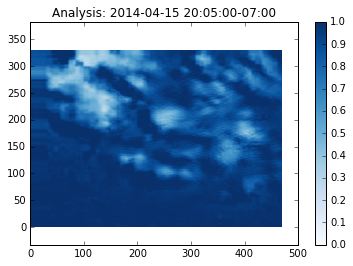

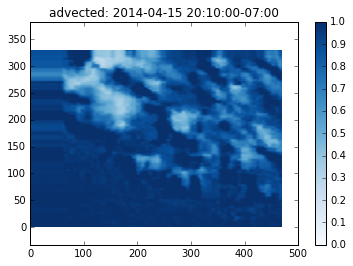

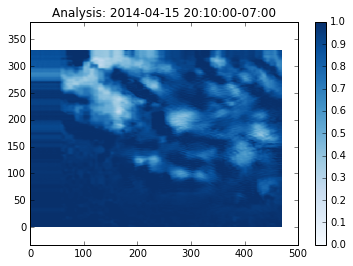

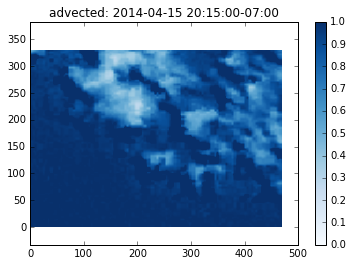

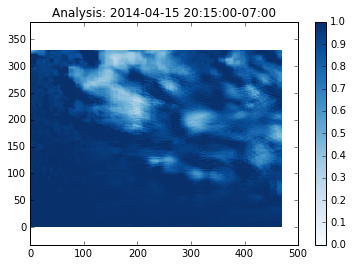

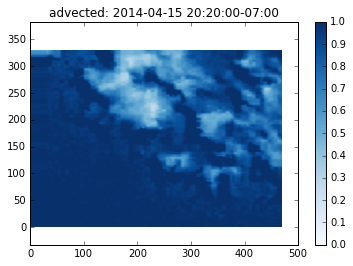

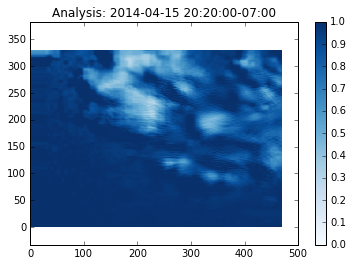

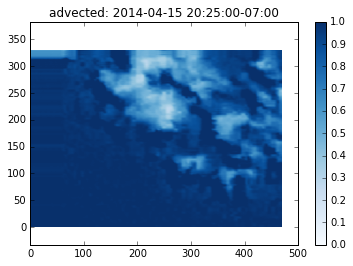

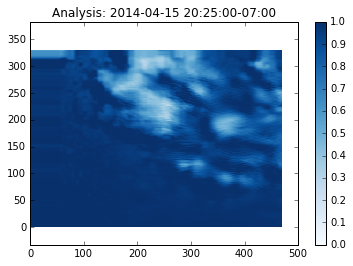

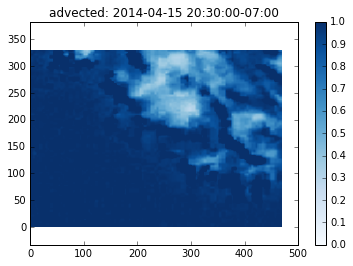

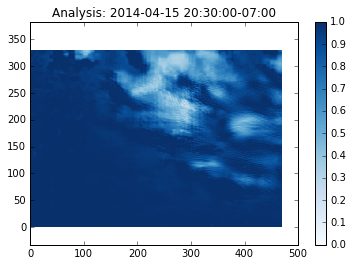

In [57]:
shape = (330, 469)
for t in range(time_range_d.size):
    this_time = time_range_d[t]
    
#     plt.figure()
#     im = plt.pcolormesh(
#         background_d[t, 2:].reshape(shape) ,
#         cmap='Blues', vmin=0, vmax=1)
#     plt.colorbar(im)
#     plt.title('Background: ' + str(this_time))
#     plt.axis('equal')

    plt.figure()
    im = plt.pcolormesh(
        advected_d[t].reshape(shape),
        cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title('advected: ' + str(this_time))
    plt.axis('equal')
    
    plt.figure()
    im = plt.pcolormesh(
        (analysis_d[t, 2:]).reshape(shape),
        cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')

In [26]:
from functools import partial

In [30]:
start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

assimilation_grid_size = 5


short_fun_d = partial(lf.main,
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_ave.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, inflation=inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

In [31]:
%lprun -f lf.main short_fun_d()

time_index: 0
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 1
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 2
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 3
advection_number: 0
advection_number: 1
advection_number: 2
